$\large \text{REQUIREMENT 5: SLIGHTLY NON-STATIONARY ENVIRONMENTS WITH MULTIPLE PRODUCTS}$ 

Extend Combinatorial-UCB with sliding window (considering the number of changes known)

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import uniform
import itertools
from joblib import Parallel, delayed

In [2]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    def __init__(self, N, T, R, prices, costs):

        #Set of possible prices
        self.prices = prices

        #Number of possible prices
        self.K = len(self.prices)

        #Number of products
        self.N = N

        #Time horizon
        self.T = T

        #Changing distribution time interval
        self.R = R

        #Valuations
        self.valuations = np.zeros((self.N, self.T))

        #Production costs
        self.production_costs = costs

        #Reward matrix: rewards for each (product,price,round)
        self.reward_matrix = np.zeros((self.N, self.K, self.T))

        #Matrix of selling probabilities: selling probabilities for each (product,price,round)
        self.sell_probabilities_matrix = np.zeros((self.N, self.K, self.T))

        #Slightly non-stationary environment: distributions of the valuations change through time.
        #All distributions are uniform and every R rounds they change.
        #FRAMEWORK: the distribution associated to the valuation of the i-th product
        #switches to the one associated to the valuation of the (i+1)-th product
        means = np.linspace(0.2, 0.8, self.N)

        for t in range(self.T):

            # Update the mean every R rounds
            if (t % self.R == 0) and (t > 0):
                means=np.concatenate(([means[-1]], means[:-1])) # change the mean

            L = 0.4  #Width of the intervals of the distributions
            sell_probabilities_list = []


            #Generate valuations and sell probabilities
            for i, mu in enumerate(means):
                low = max(0, mu - L / 2)
                high = min(1, mu + L / 2)
                dist = uniform(loc=low, scale=high - low)
                self.valuations[i,t]=dist.rvs()
                sell_probs = 1 - dist.cdf(prices) 
                sell_probabilities_list.append(sell_probs)

                #Compute the selling results and the rewards
                for k in range(self.K):
                    s_t = int(self.prices[k]<=self.valuations[i,t])
                    self.reward_matrix[i, k, t] = (self.prices[k] - self.production_costs[i]) * s_t

            #Matrix containing in each row the vectors sell_prob for each one of the N products
            self.sell_probabilities_matrix[:, :, t] = np.vstack(sell_probabilities_list)

        #Current round
        self.t = 0

    def round(self, p_t_vector):

        s_t_vector = np.zeros(self.N, dtype=int)
        f_t_vector = np.zeros(self.N)

        #No more budget: no selling procedure
        if np.all(p_t_vector == -1):
            return s_t_vector, f_t_vector

        else:
            for i in range(self.N):

                #Retrieve the utility
                f_t_vector[i] = self.reward_matrix[i, p_t_vector[i], self.t]

                #Selling results: if the utility is >0 the unit has been sold
                s_t_vector[i] = int(f_t_vector[i] > 0)

            #Update the current round
            self.t += 1

            return s_t_vector, f_t_vector

In [3]:
############################################################ CLASS SLIDING WINDOW SELLER ###################################################################################################################

class SWUCBLikeSeller():

    def __init__(self, K, stock, T, N, W, range=1):

        #Number of prices
        self.K = K

        #Time horizon
        self.T = T

        #Number of products
        self.N = N

        #Window size
        self.W = W

        #Scaling factor (set as 1)
        self.range = range

        #Chosen superarm (set of indices)
        self.p_t_vector = np.zeros(self.N, dtype=int)

        #Cache for utilities - separate cache for each product
        self.cache_f = np.full((self.N, self.W, K), np.nan)

        #Cache for selling results - separate cache for each product
        self.cache_s = np.full((self.N, self.W, K), np.nan)

        #Stock
        self.stock = stock

        #Budget per round
        self.rho = self.stock/T

        #Current round
        self.t = 0

        #Auxiliary vector used to update after having used a superarm
        self.cols_t = np.zeros(self.N)

    def pull_arm(self):

        #Matrices used to store UCBs of utilities and LCBs of selling results respectively
        UCB_matrix_t = np.zeros((self.N, self.K), dtype=float)
        LCB_matrix_t = np.zeros((self.N, self.K), dtype=float)

        #No selling procedure: no more stock available
        if self.stock < self.N:
            self.p_t_vector = np.full(self.N, -1)
            return self.p_t_vector

        # Calculate pulls in last W rounds for each product-price pair
        n_pulls_last_w = self.W - np.isnan(self.cache_f).sum(axis=1)  # Shape: (N, K)

        #Exploration: if any product-price pair hasn't been pulled enough
        if np.min(n_pulls_last_w) == 0:
            
            # Find product and price with minimum pulls
            min_indices = np.where(n_pulls_last_w == 0)
            
            if len(min_indices[0]) > 0:
                # Choose first unpulled combination
                product_idx = min_indices[0][0]
                price_idx = min_indices[1][0]
                self.p_t_vector = np.full(self.N, price_idx)
                self.cols_t = self.p_t_vector.astype(int)
                return self.p_t_vector

        # Exploitation: calculate UCBs and LCBs using sliding window
        for i in range(self.N):
            for k in range(self.K):
                if n_pulls_last_w[i, k] > 0:
                    
                    # Average over last W rounds
                    avg_f = np.nanmean(self.cache_f[i, :, k])
                    avg_s = np.nanmean(self.cache_s[i, :, k])

                    # UCB for utility
                    UCB_matrix_t[i, k] = avg_f + self.range * np.sqrt(2*np.log(self.W)/n_pulls_last_w[i, k])

                    # LCB for selling probability
                    LCB_matrix_t[i, k] = max(0, avg_s - self.range * np.sqrt(2*np.log(self.W)/n_pulls_last_w[i, k]))
                    
                else:
                    
                    UCB_matrix_t[i, k] = float('inf') 
                    LCB_matrix_t[i, k] = 0

        #List of vectors: list of all the possible superarms
        possible_superarms = list(itertools.product(range(self.K), repeat=self.N))
        number_of_possible_superarms = len(possible_superarms)
        s_lcb_super = np.array([])
        f_ucb_super = np.array([])

        #UCBs of the utilities and LCBs of the selling results related to the superarms
        for C in possible_superarms:
            R = np.arange(self.N)
            f_ucb_super = np.append(f_ucb_super, np.sum(UCB_matrix_t[R, C]))
            s_lcb_super = np.append(s_lcb_super, np.sum(LCB_matrix_t[R, C]))

        #Linear program 
        f = -f_ucb_super
        A_ub = [s_lcb_super]
        b_ub = [self.rho]
        A_eq = [np.ones(number_of_possible_superarms)]
        b_eq = [1]
        res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x

        #Sample the price 
        index_p_t_vector = np.random.choice(number_of_possible_superarms, p=gamma)
        self.p_t_vector = np.array(possible_superarms[index_p_t_vector], dtype=int)

        #Update cols_t
        self.cols_t = self.p_t_vector.astype(int)

        return self.p_t_vector

    def update(self, s_t_vector, f_t_vector):

        cols = self.cols_t.astype(int)

        # Update sliding window cache for each product
        for i in range(self.N):
            
            # Remove oldest observation (shift window)
            self.cache_f[i, :-1, :] = self.cache_f[i, 1:, :]  
            self.cache_s[i, :-1, :] = self.cache_s[i, 1:, :]  

            # Fill the last row with NaN
            self.cache_f[i, -1, :] = np.nan
            self.cache_s[i, -1, :] = np.nan

            # Add new observation in the last row
            self.cache_f[i, -1, cols[i]] = f_t_vector[i]
            self.cache_s[i, -1, cols[i]] = s_t_vector[i]

        #Decrease the stock
        self.stock -= np.sum(s_t_vector)

        #Update the current round
        self.t += 1


In [4]:
############################################################ CLAIRVOYANT ###################################################################################################################

def compute_clairvoyant(N, K, prices, production_costs, rho, T, R):
    
    #Slightly non-stationary environment: distributions of the valuations change through time.
    #All distributions are uniform and every R rounds they change.
    #FRAMEWORK: the distribution associated to the valuation of the i-th product
    #switches to the one associated to the valuation of the (i+1)-th product
    means = np.linspace(0.2, 0.8, N)
    
    L = 0.4 #Width of the intervals of the distributions

    total_expected_utility = 0

    # Update the mean every R rounds
    for phase in range(T // R + 1):
        
        if phase > 0:
            
            means = np.concatenate(([means[-1]], means[:-1]))#change the mean

        sell_probabilities_list = []
        
        #Generate valuations and sell probabilities
        for mu in means:
            low = max(0, mu - L/2)
            high = min(1, mu + L/2)
            dist = uniform(loc=low, scale=high - low)
            sell_probs = 1 - dist.cdf(prices)
            sell_probabilities_list.append(sell_probs)

        #Matrix containing in each row the vectors sell_prob for each one of the N products
        sell_probabilities_matrix = np.vstack(sell_probabilities_list)

        #List of superarms
        possible_superarms = list(itertools.product(range(K), repeat=N))
        
        exp_s_super = np.array([])
        exp_f_super = np.array([])

        #Compute the utility and selling results of the superarms
        for C in possible_superarms:
            R_idx = np.arange(N)
            exp_s_super = np.append(exp_s_super, np.sum(sell_probabilities_matrix[R_idx, C]))
            exp_f_super = np.append(exp_f_super, np.sum((prices[np.array(C)] - production_costs) * sell_probabilities_matrix[R_idx, C]))

        #Linear Program
        f = -exp_f_super
        A_ub = [exp_s_super]
        b_ub = [rho]
        A_eq = [np.ones(len(possible_superarms))]
        b_eq = [1]
        res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))

        #Expected utility of the phase
        phase_utility = -res.fun
        
        #Duration of the phase
        phase_length = min(R, T - phase * R)
        
        #Total expected utility 
        total_expected_utility += phase_utility * phase_length
        
    #Averaged total expected utility 
    return total_expected_utility / T

Average depletion time: 807
Average cumulative utility: 371.2


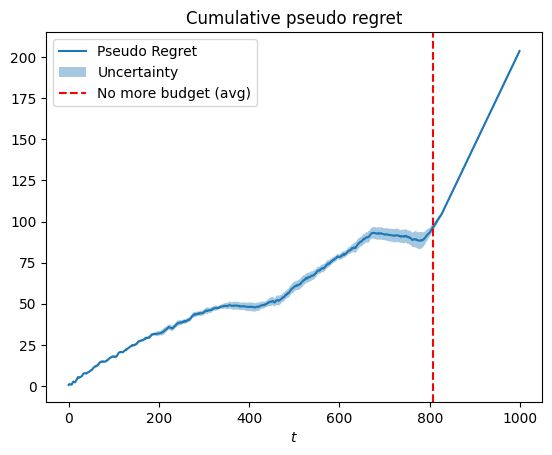

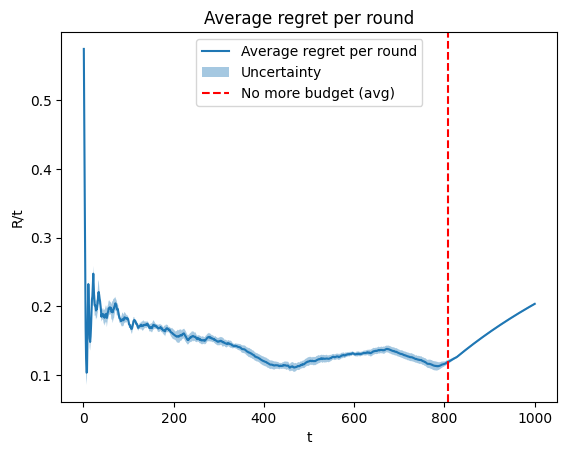

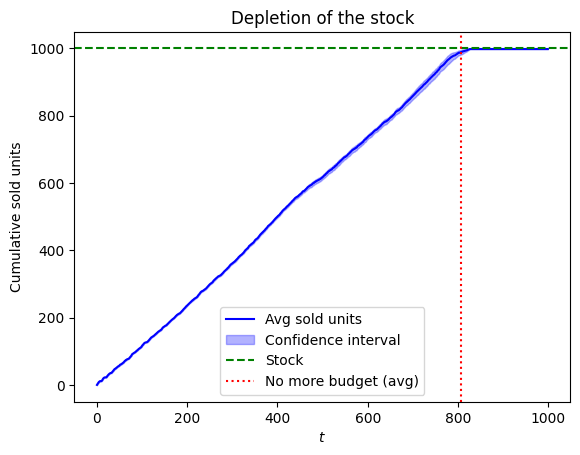

In [5]:
############################################################ EXPERIMENT ###################################################################################################################

#Setting
N = 3
T = 1000
prices = np.linspace(0.1, 1.1, 11)
costs = 0.1 * np.ones(N)
K = len(prices)
stock = 1000
#stock=750 (for comparison with Requirement 4)
R = int(T/3)
W = R
rho = stock / T
n_trials = 3

util_per_trial=[]
exhaustion_times=[]

#CLAIRVOYANT
means = np.linspace(0.2, 0.8, N)
L = 0.4

sell_probabilities_list = []
for mu in means:
    low = max(0, mu - L/2)
    high = min(1, mu + L/2)
    dist = uniform(loc=low, scale=high - low)
    sell_probs = 1 - dist.cdf(prices)
    sell_probabilities_list.append(sell_probs)

sell_probabilities_matrix = np.vstack(sell_probabilities_list)

OPT = compute_clairvoyant(N, K, prices, costs, rho, T, R)

#Function to be parallelized
def run_single_trial(seed=None):
    if seed is not None:
        np.random.seed(seed)  #OPTIONAL: seed for reproducibility

    ucb_seller = SWUCBLikeSeller(K, stock, T, N, W, range=1)  
    env = buyer(N, T, R, prices, costs)

    seller_utilities = np.array([])
    products_sold = np.array([])
    exhausted_at = T

    # Experiment
    for u in range(T):
        vect_p_t = ucb_seller.pull_arm()
        if np.all(vect_p_t == -1):
            exhausted_at = u
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)

            ucb_seller.update(vect_s_t, vect_f_t)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)
        

    if len(seller_utilities) < T:
        seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
    if len(products_sold) < T:
        products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
    
    tot_util=np.sum(seller_utilities)

    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)

    return cumulative_regret, exhausted_at, products_sold,tot_util


#Parallelization of the trials
results = Parallel(n_jobs=-1)(delayed(run_single_trial)(seed) for seed in range(n_trials))

#Results
regret_per_trial, exhaustion_times, products_sold_trials,util_per_trial = zip(*results)

regret_per_trial = np.array(regret_per_trial)
products_sold_trials = np.array(products_sold_trials)

util_per_trial=np.array(util_per_trial,dtype=float)
avg_util=util_per_trial.mean()


#Mean and standard deviation of the regret
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# Correction for the avg_cumulative_sold
cumulative_sold_trials = np.array([np.cumsum(p) for p in products_sold_trials])
avg_cumulative_sold = cumulative_sold_trials.mean(axis=0)
sold_sd = cumulative_sold_trials.std(axis=0)

# Prints: 

avg_exhaustion_time = int(np.mean(exhaustion_times))
print("Average depletion time:",avg_exhaustion_time)

print("Average cumulative utility:",avg_util)

############################################################ PLOTS ###################################################################################################################

#Plot 1: Cumulative pseudo regret vs time

plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.title('Cumulative pseudo regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.xlabel('$t$')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')

plt.legend()
plt.show()


#Plot 2: Average Regret per round

times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round')
plt.title('Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')

plt.xlabel('t')
plt.ylabel('R/t')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()


#Plot 3: Number of units sold vs time

plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")

plt.fill_between(np.arange(T),
                 avg_cumulative_sold - sold_sd/np.sqrt(n_trials),
                 avg_cumulative_sold + sold_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.3, label="Confidence interval")

plt.axhline(y=stock, color='green', linestyle='--', label='Stock')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')

plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()

Extend Combinatorial-UCB with sliding window (considering the number of changes unknown)

Average depletion time: 934


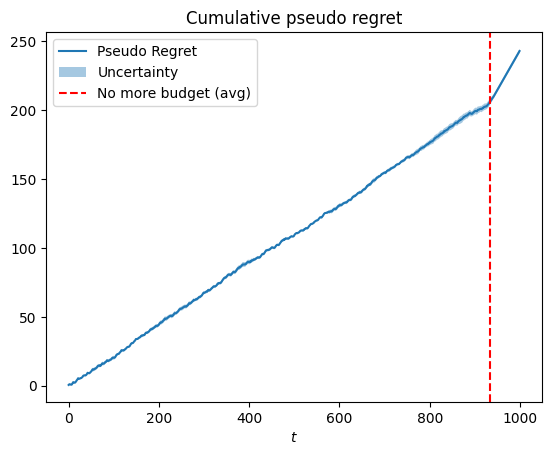

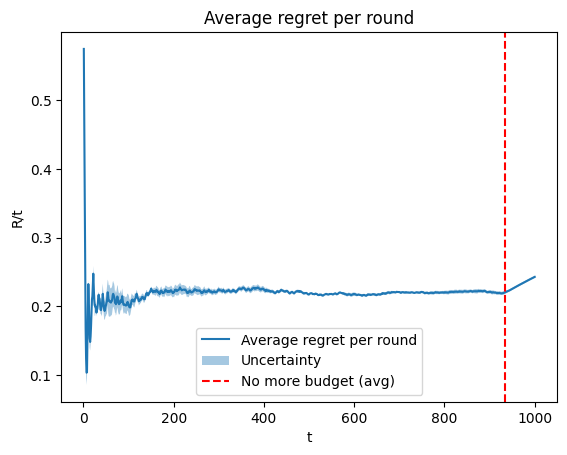

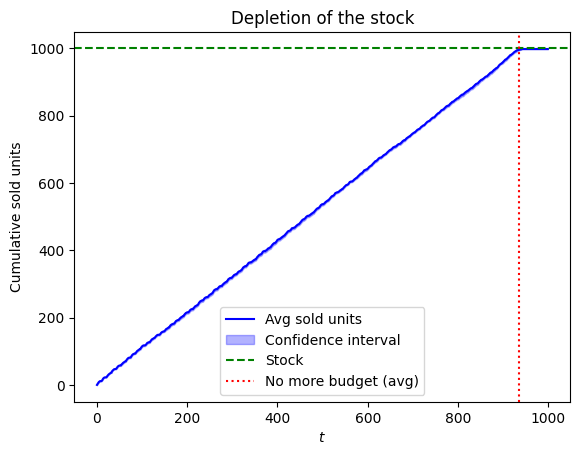

In [6]:
############################################################ EXPERIMENT ###################################################################################################################

#Setting
N = 3
T = 1000
prices = np.linspace(0.1, 1.1, 11)
costs = 0.1 * np.ones(N)
K = len(prices)
stock = 1000
R = int(T/3)
W = int(np.sqrt(T))
rho = stock / T
n_trials = 3

#CLAIRVOYANT
means = np.linspace(0.2, 0.8, N)
L = 0.4

sell_probabilities_list = []
for mu in means:
    low = max(0, mu - L/2)
    high = min(1, mu + L/2)
    dist = uniform(loc=low, scale=high - low)
    sell_probs = 1 - dist.cdf(prices)
    sell_probabilities_list.append(sell_probs)

sell_probabilities_matrix = np.vstack(sell_probabilities_list)

OPT = compute_clairvoyant(N, K, prices, costs, rho, T, R)

#Function to be parallelized
def run_single_trial(seed=None):
    if seed is not None:
        np.random.seed(seed)  #OPTIONAL: seed for reproducibility

    ucb_seller = SWUCBLikeSeller(K, stock, T, N, W, range=1)  
    env = buyer(N, T, R, prices, costs)

    seller_utilities = np.array([])
    products_sold = np.array([])
    exhausted_at = T

    # Experiment
    for u in range(T):
        vect_p_t = ucb_seller.pull_arm()
        if np.all(vect_p_t == -1):
            exhausted_at = u
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)

            ucb_seller.update(vect_s_t, vect_f_t)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)

    if len(seller_utilities) < T:
        seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
    if len(products_sold) < T:
        products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))

    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)

    return cumulative_regret, exhausted_at, products_sold


#Parallelization of the trials
results = Parallel(n_jobs=-1)(delayed(run_single_trial)(seed) for seed in range(n_trials))

#Results
regret_per_trial, exhaustion_times, products_sold_trials = zip(*results)
regret_per_trial = np.array(regret_per_trial)
products_sold_trials = np.array(products_sold_trials)

#Mean and standard deviation of the regret
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# Correction for the avg_cumulative_sold
cumulative_sold_trials = np.array([np.cumsum(p) for p in products_sold_trials])
avg_cumulative_sold = cumulative_sold_trials.mean(axis=0)
sold_sd = cumulative_sold_trials.std(axis=0)

# Prints: 

avg_exhaustion_time = int(np.mean(exhaustion_times))
print("Average depletion time:",avg_exhaustion_time)

############################################################ PLOTS ###################################################################################################################

#Plot 1: Cumulative pseudo regret vs time

plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.title('Cumulative pseudo regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.xlabel('$t$')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')

plt.legend()
plt.show()


#Plot 2: Average Regret per round

times = np.arange(1, T+1)
plt.plot(times, (average_regret / times), label='Average regret per round')
plt.title('Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')

plt.xlabel('t')
plt.ylabel('R/t')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()


#Plot 3: Number of units sold vs time

plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")

plt.fill_between(np.arange(T),
                 avg_cumulative_sold - sold_sd/np.sqrt(n_trials),
                 avg_cumulative_sold + sold_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.3, label="Confidence interval")

plt.axhline(y=stock, color='green', linestyle='--', label='Stock')

if len(exhaustion_times) > 0:
    avg_exhaustion_time = int(np.mean(exhaustion_times))
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')

plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()

$\large\text{Compare}$

Compare the performance of combinatorial-UCB with sliding window with the primal-dual method

Average exhaustion time: 850
Average cumulative utility: 271.32000000000005


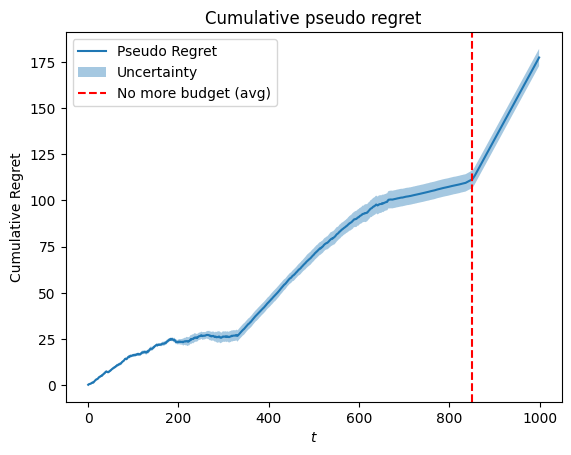

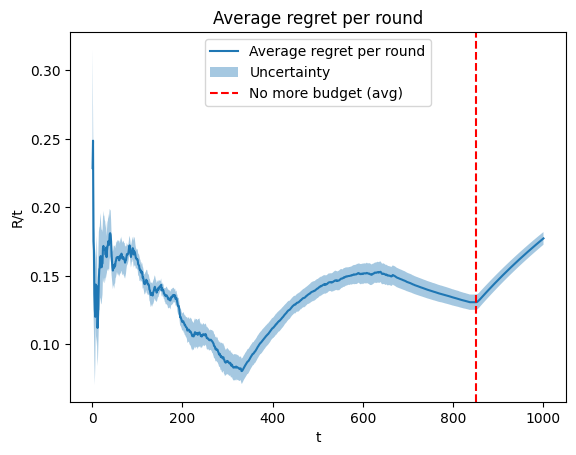

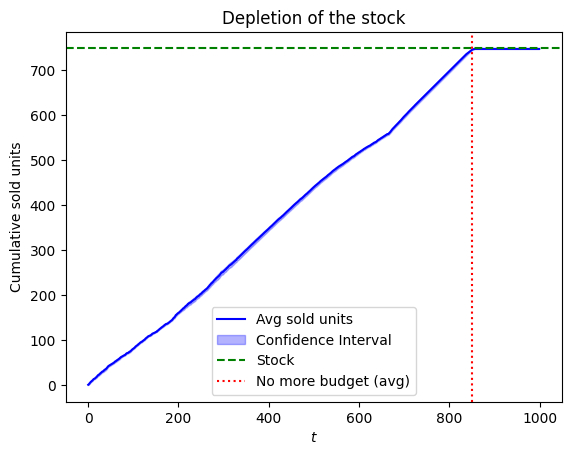

In [7]:
############################################################ CLASS BUYER ###################################################################################################################

class buyer():
    def __init__(self, N, T, R, prices, costs):

        #Set of possible prices
        self.prices = prices

        #Number of possible prices
        self.K = len(self.prices)

        #Number of products
        self.N = N

        #Time horizon
        self.T = T

        #Changing distribution time interval
        self.R = R

        #Valuations
        self.valuations = np.zeros((self.N, self.T))

        #Production costs
        self.production_costs = costs

        #Reward matrix: rewards for each (product,price,round)
        self.reward_matrix = np.zeros((self.N, self.K, self.T))
        
        #Matrix of selling results: selling results for each (product,price,round)
        self.selling_results_matrix=np.zeros((self.N, self.K, self.T))

        #Matrix of selling probabilities: selling probabilities for each (product,price,round)
        self.sell_probabilities_matrix = np.zeros((self.N, self.K, self.T))

        #Slightly non-stationary environment: distributions of the valuations change through time.
        #All distributions are uniform and every R rounds they change.
        #FRAMEWORK: the distribution associated to the valuation of the i-th product
        #switches to the one associated to the valuation of the (i+1)-th product
        means = np.linspace(0.2, 0.8, self.N)

        for t in range(self.T):

            # Update the mean every R rounds
            if (t % self.R == 0) and (t > 0):
                means=np.concatenate(([means[-1]], means[:-1])) # change the mean

            L = 0.4  #Width of the intervals of the distributions
            sell_probabilities_list = []


            #Generate valuations and sell probabilities
            for i, mu in enumerate(means):
                low = max(0, mu - L / 2)
                high = min(1, mu + L / 2)
                dist = uniform(loc=low, scale=high - low)
                self.valuations[i,t]=dist.rvs()
                sell_probs = 1 - dist.cdf(prices) 
                sell_probabilities_list.append(sell_probs)

                #Compute the selling results and the rewards
                for k in range(self.K):
                    s_t = int(self.prices[k]<=self.valuations[i,t])
                    self.selling_results_matrix[i, k, t]=s_t
                    self.reward_matrix[i, k, t] = (self.prices[k] - self.production_costs[i]) * s_t

            #Matrix containing in each row the vectors sell_prob for each one of the N products
            self.sell_probabilities_matrix[:, :, t] = np.vstack(sell_probabilities_list)

        #Current round
        self.t = 0

    def round(self, p_t_vector):

        s_t_vector = np.zeros(self.N, dtype=int)
        f_t_vector = np.zeros(self.N)

        #No more budget: no selling procedure
        if np.all(p_t_vector == -1):
            return s_t_vector, f_t_vector

        else:
            for i in range(self.N):

                #Retrieve the utility
                f_t_vector[i] = self.reward_matrix[i, p_t_vector[i], self.t]

                #Selling results: if the utility is >0 the unit has been sold
                s_t_vector[i] = int(f_t_vector[i] > 0)

            #Update the current round
            self.t += 1

            return s_t_vector, f_t_vector



############################################################ HEDGE ###################################################################################################################

class HedgeAgent:
    
    def __init__(self,N, K, learning_rate):
        
        #Number of prices
        self.K = K
        
        #Number of products
        self.N=N
        
        #Learning rate
        self.learning_rate = learning_rate
        
        #Weights for each (product,price)
        self.weights = np.ones((N,K))
        
        #Distributions
        self.x_t = np.ones((N,K))/K
        
        #Chosen prices (vector of indices)
        self.p_t=-1*np.ones(self.N,dtype=int)
        
        #Current round
        self.t = 0

    def pull_arm(self):
        
        for n in range(self.N):
            
            #Update weights
            self.x_t[n,:] = self.weights[n,:]/(np.sum(self.weights[n,:]))
            
            #Choose the price for each product
            self.p_t[n] = np.random.choice(np.arange(self.K), p=self.x_t[n,:])
             
        return self.p_t
    
    def update(self, loss_mat):
        
        for n in range(self.N):
            
            #Update weights for each (product,price)
            self.weights[n,:] *= np.exp(-self.learning_rate*loss_mat[n,:])
            
        #Update the current round
        self.t += 1
        



######################################################### CLASS SELLER: ###################################################################################################################

class MultiplicativePacingSeller():
    
    def __init__(self, N, prices, costs, stock, T, eta):
        
        #Number of products
        self.N=N
        
        #Set of possible prices
        self.prices = prices
        
        #Production costs
        self.production_cost = costs
        
        #Number of possible prices
        self.K = len(prices)
        
        #Hedge Agent
        self.hedge = HedgeAgent(self.N, self.K, np.sqrt(np.log(self.K)/T))
        
        #Stock
        self.stock = stock
        
        #Eta
        self.eta = eta
        
        #Time horizon
        self.T = T
        
        #Budget per round (giusto che sia /self.N?)
        self.rho = np.ones((self.N, self.K)) * (self.stock / (self.N*self.T))  
        
        #Lambda
        self.lmbd = np.ones((self.N,self.K))
        
        #Number of pulls for each (product,price)
        self.N_pulls = np.zeros((self.N,self.K),dtype=int)
        
        #Chosen prices (vector of indices)
        self.p_t=-1*np.ones(self.N,dtype=int)

    def pull_arm(self):
        
        #No more budget available: stop selling procedure
        if self.stock < self.N: 
            self.p_t=np.full(self.N, -1)
            return self.p_t
        
        #Choose the prices
        self.p_t = self.hedge.pull_arm()
        
        return self.p_t

    def update(self, s_t, buyer_valuation):
            
            #Matrix of selling results per (product,price)
            S_t = np.zeros((self.N, self.K), dtype=int)
            
            #Matrix of utilities per (product,price)
            F_t = np.zeros((self.N, self.K), dtype=float)
            
            #Matrix of Lagrangian functions per (product,price)
            L = np.zeros((self.N, self.K), dtype=float)
            
            #Vector of the differences between the maximum of the prices and the production cost of the products
            R_max = np.zeros(self.N)
            
            #Auxiliary matrices (see below)
            L_max = np.zeros((self.N, self.K))
            L_min = np.zeros((self.N, self.K))
            L_norm = np.zeros((self.N, self.K))
        
            for n in range(self.N):
                
                ##If the buyer buys the product we return 1 (0 othewise)
                S_t[n, :] = (self.prices <= buyer_valuation[n]).astype(int)
                
                #Utility 
                F_t[n, :] = (self.prices - self.production_cost[n]) * S_t[n, :]
                
                #Lagrangian function
                L[n, :] = F_t[n, :] - self.lmbd[n, :] * (S_t[n, :] - self.rho[n, :])
                
                #Difference between the maximum of the prices and the production cost for each product
                R_max[n] = np.unique(self.prices)[-2] - self.production_cost[n]
                
                #Pacing
                pacing_max = np.maximum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))
                pacing_min = np.minimum(-self.lmbd[n, :] * (-self.rho[n, :]),
                                        -self.lmbd[n, :] * (1 - self.rho[n, :]))

                #Normalization of the Lagrangian
                L_max[n, :] = R_max[n] + pacing_max
                L_min[n, :] = pacing_min
                denom = (L_max[n, :] - L_min[n, :])
                L_norm[n, :] = np.clip((L[n, :] - L_min[n, :]) / denom, 0, 1)
                
                #Update lambda: Online Gradient Descent
                self.lmbd[n,:] = np.clip(self.lmbd[n,:] - self.eta * (self.rho[n,:] - S_t[n,:]), a_min=0, a_max=1/self.rho[n,:])
            
            #Update Hedge Agent
            self.hedge.update(1 - L_norm)
            
            #Reduce the stock
            sold_quantity = np.sum(s_t)
            self.stock -= sold_quantity 
            
            #Update the matrix of number of pulls
            rows=np.arange(self.N)
            self.N_pulls[rows,self.p_t] += 1
            

######################################################### CLAIRVOYANT ###################################################################################################################

def clairvoyant(prices, T, cost, rho, selling_results):
    
    #OUTPUT: clairvoyant utility

    #Number of products
    N = len(cost)
    
    #Number of possible prices
    K = len(prices)
    
    # Emplirical win probabilities
    win_probabilities = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            num_sold = np.sum(selling_results[n, k, :])
            win_probabilities[n, k] = num_sold / T

    #List of vectors: list of all the possible superarms
    possible_superarms = list(itertools.product(range(K), repeat=N))
    num_superarms = len(possible_superarms)
    
    
    s_super = np.array([])
    f_super = np.array([])

    #Utilities and selling results related to the superarms 
    for idx in possible_superarms:
        
        R=np.arange(N)
        s_super=np.append(s_super, np.sum(win_probabilities[R,idx]))
        f_super=np.append(f_super, np.sum((prices[np.array(idx)] - c) * win_probabilities[R,idx]))

    #Linear Program
    f = - f_super
    A_ub = [s_super]    
    b_ub = [rho]
    A_eq = [np.ones(num_superarms)]  
    b_eq = [1]

    res = optimize.linprog(f, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))

    OPT = -res.fun
    return OPT

############################################################ EXPERIMENT ###################################################################################################################

# Setting
N = 3
T = 1000
prices = np.linspace(0.1, 1.1, 11)
c = 0.1*np.ones(N)
K = len(prices)
stock = 750
R = int(T/3)
rho = stock/T
n_trials = 5
eta = 1/(np.sqrt(T))


util_per_trial=[]
regret_per_trial = []
sold_per_trial = []
exhaustion_times = []

for n in range(n_trials):

    env = buyer(N, T, R, prices, c)
    
    # CLAIRVOYANT
    OPT = clairvoyant(prices, T, c, rho, env.selling_results_matrix)
    
    seller = MultiplicativePacingSeller(N, prices, c, stock, T, eta)
    
    seller_utilities = np.array([])
    products_sold = np.array([])
    tot_util=np.array([])

    # Experiment
    for t in range(T):
        vect_p_t = seller.pull_arm()        
        if np.all(vect_p_t == -1): 
            exhaustion_times.append(t)
            # Completa con zeri fino a T
            seller_utilities = np.append(seller_utilities, np.zeros(T - len(seller_utilities)))
            products_sold = np.append(products_sold, np.zeros(T - len(products_sold)))
            break
        else:
            vect_s_t, vect_f_t = env.round(vect_p_t)
            S_t = np.sum(vect_s_t)
            F_t = np.sum(vect_f_t)
            val = env.valuations[:, t]
            seller.update(vect_s_t, val)
            seller_utilities = np.append(seller_utilities, F_t)
            products_sold = np.append(products_sold, S_t)
            
    tot_util=np.sum(seller_utilities)
    util_per_trial.append(tot_util)
            
    # Cumulative regret
    vect_1 = np.repeat(OPT, T)
    cumulative_regret = np.cumsum(vect_1 - seller_utilities)
    regret_per_trial.append(cumulative_regret)
    
    # Cumulative sold units
    sold_per_trial.append(np.cumsum(products_sold))

regret_per_trial = np.array(regret_per_trial)
sold_per_trial = np.array(sold_per_trial)
util_per_trial=np.array(util_per_trial)

# Mean and standard deviation
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

avg_cumulative_sold = sold_per_trial.mean(axis=0)
sold_sd = sold_per_trial.std(axis=0)

avg_util=util_per_trial.mean(axis=0)

avg_exhaustion_time = int(np.mean(exhaustion_times)) if exhaustion_times else None

# Prints

print("Average exhaustion time:",avg_exhaustion_time)

print("Average cumulative utility:",avg_util)

############################################################ PLOTS ###################################################################################################################

# Plot 1: Cumulative pseudo regret vs time 
plt.plot(np.arange(T), average_regret, label='Pseudo Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 alpha=0.4,
                 label='Uncertainty')
plt.title('Cumulative pseudo regret')
plt.xlabel('$t$')
plt.ylabel('Cumulative Regret')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 2: Average regret per round 
times = np.arange(1, T+1)
plt.plot(times, average_regret / times, label='Average regret per round')
plt.fill_between(times,
                 average_regret/times - regret_sd/(np.sqrt(n_trials)*times),
                 average_regret/times + regret_sd/(np.sqrt(n_trials)*times),
                 alpha=0.4,
                 label='Uncertainty')
plt.title('Average regret per round')
plt.xlabel('t')
plt.ylabel('R/t')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle='--', label='No more budget (avg)')
plt.legend()
plt.show()

# Plot 3: Number of units sold vs time with IC
ci_upper = avg_cumulative_sold + sold_sd/np.sqrt(n_trials)
ci_lower = avg_cumulative_sold - sold_sd/np.sqrt(n_trials)

plt.plot(np.arange(T), avg_cumulative_sold, label="Avg sold units", color="blue")
plt.fill_between(np.arange(T), ci_lower, ci_upper, color="blue", alpha=0.3, label="Confidence Interval")
plt.axhline(y=stock, color='green', linestyle='--', label='Stock')
if avg_exhaustion_time is not None:
    plt.axvline(x=avg_exhaustion_time, color='red', linestyle=':', label='No more budget (avg)')
plt.xlabel("$t$")
plt.ylabel("Cumulative sold units")
plt.title("Depletion of the stock")
plt.legend()
plt.show()


$\large\text{Comparison results:}$

Setting the same enviroment (slightly non-stationary) and the same parameters (time horizon T=1000 and stock=750), it is possible to state that the rewards of the two algorithms are similar (both 270.ca), but generally the algorithm of requirement 4 performs slightly better. However, it requires more rounds to deplete the inventory, due to the tendecy of exploring  more. This leads to a trade-off between the two pricing methods: if the main goal is to maximize the cumulative reward the primal-dual approach is better, on the contrary, if it requested to empty the stock as soon as possible, the SW method is advisable.